In [ ]:
import sys
sys.path.append('..')

from datetime import timedelta

from Structure import Structure
from BacktestApp import BacktestApp
from plot import plot_debug_structure
from utils import is_within_specific_minutes_of_close, get_market_close_time
import pandas as pd

pd.set_option('display.max_columns', None)

def agg_func(group):
    # 当前组的 block_type，假设组内一致
    bt = group['block_type'].iloc[0]
    
    if bt == -1:
        # 找到 DIF 最小值对应的索引
        min_idx = group['DIF'].idxmin()
        extreme_date = group.loc[min_idx, 'date']
        return pd.Series({
            'DIF': group['DIF'].min(),
            'close': group['close'].min(),
            'date': extreme_date,
            'block_type': bt
        })
    elif bt == 1:
        # 找到 DIF 最大值对应的索引
        max_idx = group['DIF'].idxmax()
        extreme_date = group.loc[max_idx, 'date']
        return pd.Series({
            'DIF': group['DIF'].max(),
            'close': group['close'].max(),
            'date': extreme_date,
            'block_type': bt
        })

def get_direction(row):
    if row["ratio"] < 2: return None
    return 'BUY' if row['block_type'] == 1 else 'SELL'

class StructurePlus(Structure):
    def __init__(self, contract, pm):
        super().__init__()
        self.angle = 0.02
        self.dispear_angle = 0.04
        self.max_loss = 0.01
        self.holding_period = 50
        self.coverage_threshold = 0.6
        self.coverage_multiple_std = 1
        self.coverage_range = 60 # 计算coverage的范围 默认取最近60分钟
        self.contract = contract
        self.pm = pm
    
    def find_position(self):
        is_match = lambda item: (
            item["contract"] == self.contract and
            item["strategy"] == "StructurePlus"
        )
        return self.pm.find_position(is_match)
    
    def calculate_open_amount(self, bars):
        # net_liquidation, available_funds = self.get_available_funds()
        if self.pm.net_liquidation is None or self.pm.available_funds is None:
            print("PositionManager.calculate_open_amount net_liquidation or available_funds is None")
            return 0
        
        target_market_value = self.pm.net_liquidation * 0.1
        if target_market_value > self.pm.available_funds: return 0
        
        open_amount = target_market_value / bars.iloc[-1]['close']
        open_amount = round(open_amount / 10) * 10  # 调整为 10 的倍数
        return int(open_amount)
    
    def trend_convergence(self, df):
        """
        过滤掉DIF和DEA线走势粘合的信号

        参数:
        df: 包含DIF和DEA列的DataFrame
        window: 用于计算粘合的窗口大小（例如50行）
        threshold: 重合比例的阈值，若超过该比例则认为信号无效

        返回:
        返回一个经过滤的DataFrame
        """
        # 获取当前窗口内的DIF和DEA值
        std = df['DIF'].std() * self.coverage_multiple_std
        
        # 计算每行DIF和DEA的区间是否重合
        dif_upper = df['DIF'].std() + std
        dif_lower = df['DIF'].std() - std
        dea_upper = df['DEA'].std() + std
        dea_lower = df['DEA'].std() - std
        
        # 判断是否重合：检查区间是否交集
        is_coveraged = (dif_lower <= dea_upper) & (dif_upper >= dea_lower)[-1 * self.coverage_range:]
        
        # print(df.iloc[0]["date"], df.iloc[-1]["date"], is_coveraged.sum() / len(df) >= threshold)
        # 如果重合超过阈值，则标记为True
        return is_coveraged.sum() / len(is_coveraged) <= self.coverage_threshold
    
    def signal(self, bars):
        df = self.prepare_data(bars)
        # df = df[df['block_id'] >= (df['block_id'].max() - 3)]
        result = df.groupby('block_id').apply(agg_func, include_groups=False).reset_index()
        result['DIF_diff'] = result['DIF'].diff()
        result['close_diff'] = result['close'].diff()
        result['DIF_diff_change_ratio'] = result['DIF_diff'] / result['DIF_diff'].shift(1)
        result['close_diff_change_ratio'] = result['close_diff'] / result['close_diff'].shift(1)
        result['ratio'] = result['close_diff_change_ratio'] / result['DIF_diff_change_ratio']
        result['direction'] = result.apply(get_direction, axis=1)
        
        # result['ratio'] = result['close_diff'].diff() / result['DIF_diff'].diff() * result['block_type']
        # result['direction'] = result['ratio'].apply(lambda x: 'SELL' if x < -5 else ('BUY' if x > 5 else None))
        # result['time_delta'] = result['date'] - result['date'].shift(1)
        # result['direction'] = result.apply(lambda row: None if row['time_delta'] < pd.Timedelta(minutes=10) else row['direction'], axis=1)
        if bars.iloc[-1]["date"] == get_market_close_time(bars.iloc[-1]["date"]) - timedelta(minutes=1):
            print(result)
        if result.iloc[-1]['direction'] == "BUY" and bars.iloc[-1]['angle'] > self.angle:
            if self.trend_convergence(bars):
                return "BUY"
        if result.iloc[-1]['direction'] == "SELL" and bars.iloc[-1]['angle'] < -1 * self.angle:
            if self.trend_convergence(bars):
                return "SELL"
            
        return None
    
    def exit_signal(self, position, bars):
        """
        :params
        bars: IBKR行情数据
        position["amount"]: 持仓数量,持仓数量大于0即多单,小于0是空单
        """
        assert position["amount"] != 0, "持仓数量不能为零，结合仓位管理运行"
        df = self.prepare_data(bars)
        
        current_price = df.iloc[-1]['close']
        time_elapsed = df.iloc[-1]['date'] - position["date"]
        angle = df.iloc[-1]['angle']

        # 条件 1: MACD向背离方向变化
        # if (position["amount"] < 0 and angle >= self.dispear_angle) or (position["amount"] > 0 and angle <= -1 * self.dispear_angle):
        #     return "平仓信号：MACD背离方向变化"

        # 条件 2: 亏损达到1%
        price_change_pct = (current_price - position["price"]) / position["price"]
        if (position["amount"] > 0 and price_change_pct <= -1 * self.max_loss) or (position["amount"] < 0 and price_change_pct >= self.max_loss):
            return "平仓信号：达到亏损上限"

        # 条件 3: 持有时间超过26个周期
        if time_elapsed >= timedelta(minutes=self.holding_period):
            return "平仓信号：持有时间超限"

        return False  # 无平仓信号
    
    def update(self, bars):
        position = self.find_position()
        signal = self.signal(bars)
        direction =  { None: 0, 'BUY': 1, 'SELL': -1 }.get(signal)
        amount = self.calculate_open_amount(bars) * direction
        
        if not position:
            if signal and not is_within_specific_minutes_of_close(bars, 60):
                print(bars.iloc[-1]["date"], is_within_specific_minutes_of_close(bars, 60))
                self.pm.open_position(self.contract, "StructurePlus", amount, bars)
        else:        
            if position["amount"] * amount < 0:
                self.pm.close_position(position, bars)
                if not is_within_specific_minutes_of_close(bars, 60):
                    self.pm.open_position(self.contract, "StructurePlus", amount, bars)
            else:
                exit_signal = self.exit_signal(position, bars)
                if exit_signal:
                    print(exit_signal)
                    self.pm.close_position(position, bars)

class RBreakBacktestApp(BacktestApp):
    def __init__(self, config_file="config.yml", **kwargs):
        super().__init__(config_file, **kwargs)
        self.st_plus = { contract.symbol: StructurePlus(contract, self.pm) for contract in self.contracts }
        
    def on_bar_update(self, contract, bars, has_new_bar):
        bars = bars.copy()
        self.st_plus[contract.symbol].has_prepare_data = True
        self.st_plus[contract.symbol].data = bars
        self.st_plus[contract.symbol].update(bars)

def pre_process_bar_callback(bars):
    data_process = StructurePlus('NVDA', None)
    return data_process.prepare_data(bars)

ba = RBreakBacktestApp(config_file="../config_backtest.yml", host="host.docker.internal", clientId=19, debug=True)
end_date = "20250214"
duration_str = '20 D'
ba.minutes_backtest(end_date, duration_str, pre_process_bar_callback=pre_process_bar_callback)
ba.ib.disconnect()

2025-01-17 09:32:00-05:00 False
【2025-01-17 09:32:00-05:00】【StructurePlus】开仓: NVDA, 价格: 136.25, 数量：730, 浮动盈亏：None
平仓信号：持有时间超限
【2025-01-17 10:22:00-05:00】【StructurePlus】平仓: NVDA, 价格: 136.64, 数量：-730, 浮动盈亏：284.69999999999004
2025-01-17 10:33:00-05:00 False
【2025-01-17 10:33:00-05:00】【StructurePlus】开仓: NVDA, 价格: 137.25, 数量：730, 浮动盈亏：None
平仓信号：持有时间超限
【2025-01-17 11:23:00-05:00】【StructurePlus】平仓: NVDA, 价格: 137.86, 数量：-730, 浮动盈亏：445.30000000000996
2025-01-17 11:24:00-05:00 False
【2025-01-17 11:24:00-05:00】【StructurePlus】开仓: NVDA, 价格: 137.93, 数量：730, 浮动盈亏：None
平仓信号：持有时间超限
【2025-01-17 12:14:00-05:00】【StructurePlus】平仓: NVDA, 价格: 138.06, 数量：-730, 浮动盈亏：94.89999999999668
2025-01-17 12:15:00-05:00 False
【2025-01-17 12:15:00-05:00】【StructurePlus】开仓: NVDA, 价格: 137.99, 数量：730, 浮动盈亏：None
平仓信号：持有时间超限
【2025-01-17 13:05:00-05:00】【StructurePlus】平仓: NVDA, 价格: 137.86, 数量：-730, 浮动盈亏：-94.89999999999668
2025-01-17 14:08:00-05:00 False
【2025-01-17 14:08:00-05:00】【StructurePlus】开仓: NVDA, 价格: 137.55, 数量：-730, 浮动盈亏

In [13]:
ba.statistic()

{'cumulative_pnl': np.float64(8675.50324800075),
 'max_drawdown': np.float64(0.005947471444379688),
 'sharpe_ratio': np.float64(1.8418497999001064),
 'volatility': np.float64(0.037258357816588664),
 'daily_return': np.float64(0.0004112075352741683),
 'commission': np.float64(2725.60968)}

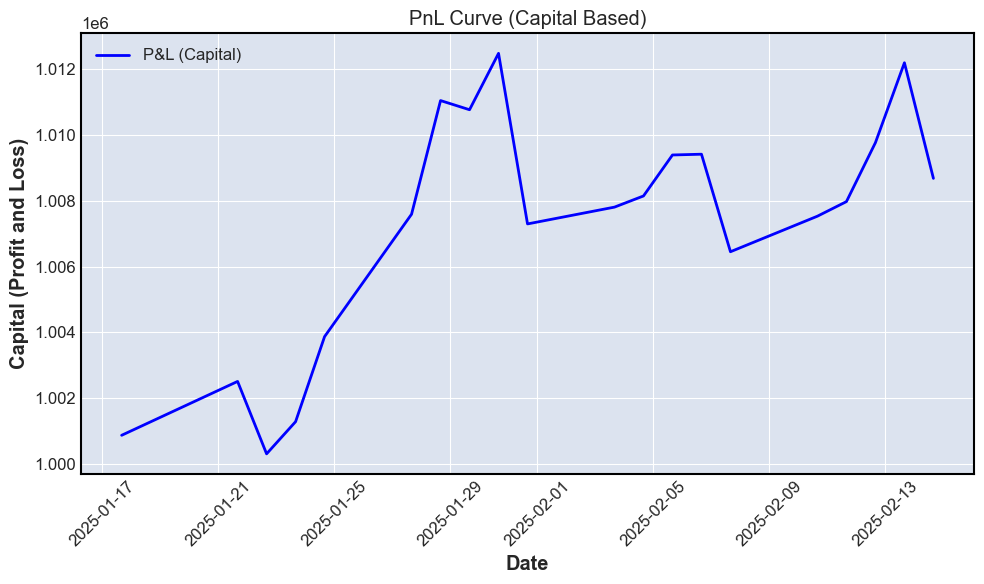

In [14]:
ba.plot_pnl()

2025-02-04
                        date symbol       strategy open_or_close direction  \
0  2025-02-04 09:32:00-05:00   NVDA  StructurePlus            开仓       BUY   
1  2025-02-04 10:22:00-05:00   NVDA  StructurePlus            平仓      SELL   
2  2025-02-04 10:40:00-05:00   NVDA  StructurePlus            开仓       BUY   
3  2025-02-04 11:13:00-05:00   NVDA  StructurePlus            平仓      SELL   
4  2025-02-04 11:13:00-05:00   NVDA  StructurePlus            开仓      SELL   
5  2025-02-04 12:03:00-05:00   NVDA  StructurePlus            平仓       BUY   
6  2025-02-04 12:19:00-05:00   NVDA  StructurePlus            开仓      SELL   
7  2025-02-04 12:53:00-05:00   NVDA  StructurePlus            平仓       BUY   
8  2025-02-04 12:53:00-05:00   NVDA  StructurePlus            开仓       BUY   
9  2025-02-04 13:04:00-05:00   NVDA  StructurePlus            平仓      SELL   
10 2025-02-04 13:04:00-05:00   NVDA  StructurePlus            开仓      SELL   
11 2025-02-04 13:37:00-05:00   NVDA  StructurePlus   

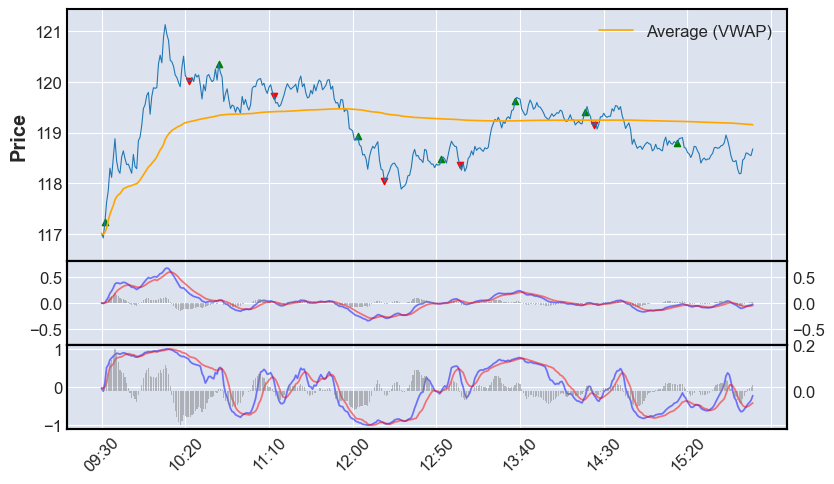

In [15]:
idx = 11
daily = ba.get_historical_data(ba.contracts[0], end_date, duration_str, '1 day')
date = daily.iloc[idx]['date']
history = pd.DataFrame(ba.pm.trade_log)
print(date)
specific_day_history = history[history['date'].dt.date == date].to_dict(orient='records')
print(pd.DataFrame(specific_day_history))
ba.st_plus['NVDA'].has_prepare_data = False
df = ba.st_plus['NVDA'].prepare_data(ba.get_historical_data(ba.contracts[0], date))
plot_debug_structure(df.set_index("date", drop=True), specific_day_history)

In [16]:
ba.ib.disconnect()
